You need to download the [Biopython](https://biopython.org/wiki/Download) library to manipulate the PDB, which can be done just with

```
pip install biopython
```

In [9]:
import rmsd
from Bio import PDB
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

parser = PDB.PDBParser()
io = PDB.PDBIO()

Here I'm using this molecule: https://alphafold.ebi.ac.uk/entry/A0A5E8G9H8 and I renamed the pdb to `ecoli.pdb`.

In [10]:
pdb_name = "ecoli"

Now to generate 20 random rotations of `ecoli.pdb` and save them as `ecoli_rX.pdb`:

(https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions)

In [11]:
def rot_x(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])

def rot_y(theta):
    return np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

def rot_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

rotations = [rot_x, rot_y, rot_z]

The following code is modified from: https://stackoverflow.com/questions/47806879/how-to-move-protein-coordinates-with-respect-to-a-reference-frame

In [12]:
n = 20

for i in range(n):
    struct = parser.get_structure(pdb_name, f'{pdb_name}.pdb')
    
    rotation_axis = np.random.choice(rotations) # rotate around x, y, or z axis
    rotation_angle = np.random.uniform(low=0, high=2*np.pi) # angle b/t 0 and 2π
    
#     print("rotate axis: ", rotation_axis.__name__)
#     print("rotate angle: ", rotation_angle)

    rotation_matrix = rotation_axis(rotation_angle)
    
    # I think this also works: https://math.stackexchange.com/questions/442418/random-generation-of-rotation-matrices
#     rotation_matrix, _ = np.linalg.qr(np.random.rand(3, 3))
    
    for atom in struct.get_atoms():
        atom_C1 = atom.coord.copy()
        break

    for model in struct:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom.transform(rotation_matrix, -atom_C1)

    io.set_structure(struct)
    io.save(f'{pdb_name}_r{i}.pdb')

Testing each rotation method on each rotation (show result and time):

In [13]:
methods = ["kabsch", "quaternion"]

# Initialize a dictionary to store the time taken for each method
time_taken = {"kabsch": [], "quaternion": []}

for i in range(n):
    print(f'{pdb_name}_r{i}.pdb')
    for method in methods:
        print(f"  {method}")
        print("    result = ", end="")
        start = timer()
        rmsd.main(["-r", method, f'{pdb_name}.pdb', f'{pdb_name}_r{i}.pdb'])
        end = timer()
        time_elapsed = end - start
        print(f"    time   = {time_elapsed} sec")
        
        # Store the time taken in the dictionary
        time_taken[method].append(time_elapsed)
    print()

ecoli_r0.pdb
  kabsch
    result = 0.0004040162179640689
    time   = 0.012656326871365309 sec
  quaternion
    result = 0.0004040162179643543
    time   = 0.032245867885649204 sec

ecoli_r1.pdb
  kabsch
    result = 0.00041091627058279217
    time   = 0.011524610687047243 sec
  quaternion
    result = 0.00041091627058265247
    time   = 0.028339640703052282 sec

ecoli_r2.pdb
  kabsch
    result = 0.00040873056674753784
    time   = 0.010218599811196327 sec
  quaternion
    result = 0.0004087305667473653
    time   = 0.028272475581616163 sec

ecoli_r3.pdb
  kabsch
    result = 0.00041334597946250277
    time   = 0.011572664137929678 sec
  quaternion
    result = 0.00041334597946268096
    time   = 0.028238522354513407 sec

ecoli_r4.pdb
  kabsch
    result = 0.00040778832487591753
    time   = 0.009933800902217627 sec
  quaternion
    result = 0.0004077883248760503
    time   = 0.029112311080098152 sec

ecoli_r5.pdb
  kabsch
    result = 0.0004058215596134496
    time   = 0.011666746344

In [14]:
# Function to visualize the time taken
def visualize_time_taken(time_taken):
    labels = [f"r{i}" for i in range(len(time_taken["kabsch"]))]
    kabsch_times = time_taken["kabsch"]
    quaternion_times = time_taken["quaternion"]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, kabsch_times, width, label='Kabsch')
    rects2 = ax.bar(x + width/2, quaternion_times, width, label='Quaternion')

    ax.set_ylabel('Time (seconds)')
    ax.set_title('Time taken by Kabsch and Quaternion methods')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

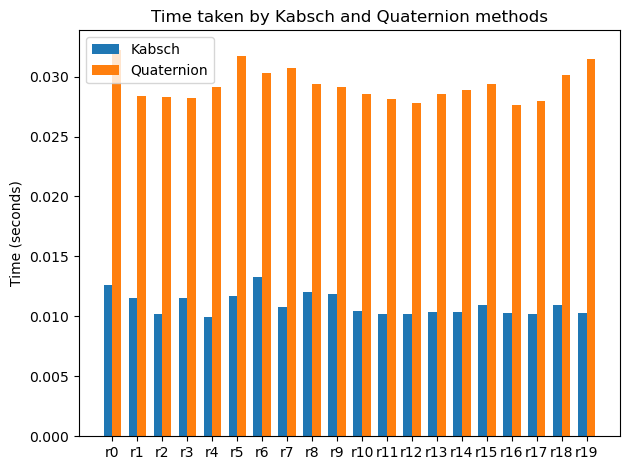

In [15]:
# Visualize the time taken
visualize_time_taken(time_taken)